In [3]:
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
import os 
warnings.filterwarnings("ignore")


In [4]:
# Symbol 
stocks = [
    'ADVANC', 'AOT', 'AWC', 'BANPU', 'BBL', 'BDMS', 'BEM', 'BGRIM', 'BH', 'BTS', 'CBG',
    'CENTEL', 'COM7', 'CPALL', 'CPF', 'CPN', 'CRC', 'DELTA', 'EA', 'EGCO', 'GLOBAL', 'GPSC', 
    'GULF', 'HMPRO', 'INTUCH', 'IVL', 'KBANK', 'KCE', 'KTB', 'KTC', 'LH', 'MINT', 'MTC', 'OR', 
    'OSP', 'PTT', 'PTTEP', 'PTTGC', 'RATCH', 'SAWAD', 'SCB', 
    'SCC', 'SCGP', 'TISCO', 'TLI', 'TOP', 'TRUE', 'TTB', 'TU', 'WHA', 
]

In [9]:
df = pd.read_csv("../data/15t/ADVANC_SET.csv")
df["Close"]

0        188.5
1        188.0
2        187.0
3        186.5
4        186.5
         ...  
10976    217.0
10977    217.0
10978    217.0
10979    218.0
10980    217.0
Name: Close, Length: 10981, dtype: float64

In [10]:
# find d integrate
from statsmodels.tsa.stattools import adfuller
tmp = df.copy()
# adf_res = adfuller(tmp['Close'], autolag = 'AIC')[1]
_ =  tmp['Close']
val = 9999
i = 0 
while val > 0.05:
    adf_res = adfuller(_.dropna(), autolag = 'AIC')
    val = adf_res[1]
    _ = _.diff(1)
    print('p-Values:' + str(val))
    i += 1
print(i)

p-Values:0.2018795108829684
p-Values:0.0
2


p=  4


5

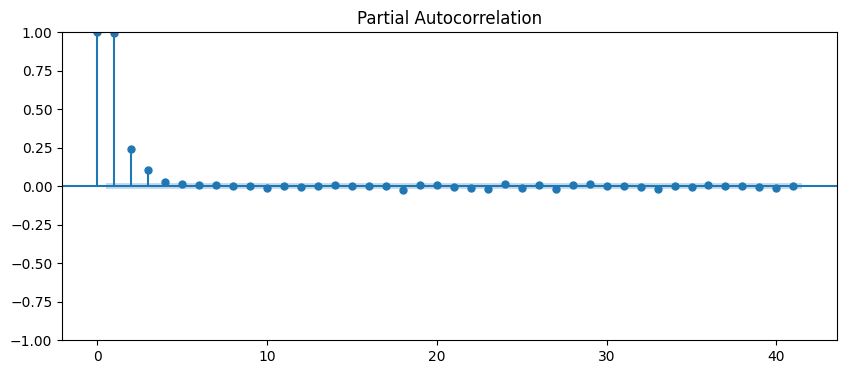

In [11]:
# find p
#Auto Regressive (p)
from statsmodels.graphics.tsaplots import  plot_pacf
from statsmodels.tsa.stattools import pacf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_pacf(df['Close'].dropna(), method = 'ols')
df_pacf = pacf(df['Close'].dropna(), method = 'ols')


import numpy as np

for i in range(0, len(df_pacf)):
    if df_pacf[i] < 1.96 / np.sqrt(len(df['Close'])):
        print('p= ', i - 1)
        break
i

In [ ]:
# find 
#Moving Average (q)
from statsmodels.graphics.tsaplots import  plot_acf
from statsmodels.tsa.stattools import acf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_acf(df['Close'], fft = True)
df_acf = acf(df['Close'], fft = True)


In [ ]:
#find q 
for i in range(0, len(df_acf)):
    if df_acf[i] < 1.96 / np.sqrt(len(df['Close'])):
        print('q=', i - 1)
        break
# q cannot find using grid search
    

In [ ]:
#Test order
import itertools

p = range(5, 6)
d = range(2,3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
print(pdq)

from statsmodels.tsa.arima.model import ARIMA

aic = []


for param in pdq:
    try:
        model = ARIMA(df['Close'].dropna(), order = param, seasonal_order=(0,1,1,5))
        results = model.fit()
        print('Order = {}'.format(param))
        print('AIC = {}'.format(results.aic))
        if results.aic > 0 :
            print("YESSSSSSSSSSSSSSSSSSSSSS")
        a = 'Order: '+str(param) +' AIC: ' + str(results.aic)
        aic.append(a)
    except:
        continue

In [ ]:
timeframe = ["15t"]
partition_data_prediction = {}
partition_data_mse = {}
for tf in timeframe:
    for symbol in stocks[1:2]:
        print(f"Timeframe = {tf}, SYMBOL = {symbol}..............")
        # df= pd.read_csv(f"./data/{tf}/{symbol}_SET.csv")
        if tf == "15t":
            train_data = df[(df['datetime'] > '2023-03-01') & (df['datetime'] < '2023-10-01')]
            training_data = train_data['Close'].values
            test_data = df[(df['datetime'] >= '2023-10-01')]
            test_data = test_data['Close'].values
        history = [x for x in training_data]
        model_predictions = []
        _prediction = []
        N_test_observations = len(test_data)
        for time_point in range(N_test_observations):
            # print(f'round ={time_point}')
            model = ARIMA(history, order=(5,2,2))
            model_fit = model.fit()
            output = model_fit.forecast(10)
            yhat = round(output[0],2)
            print("output = ", output)
            model_predictions.append(yhat)
            true_test_value = test_data[time_point]
            history.append(yhat)
            # history.append(round(output[1],2))
        MSE_error = mean_squared_error(test_data, model_predictions)
        print('Testing Mean Squared Error is {}'.format(MSE_error))
        for period_predict in range(0,2):
            model = ARIMA(history, order=(5,2,2))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            print("y_hat= ", output)
            _prediction.append(yhat)
        partition_data_mse[symbol] = MSE_error
        partition_data_prediction[symbol] = _prediction
            


In [ ]:
round(17.89112, 2)

In [ ]:
# import pickle 
# with open('partition_data_price_data.pkl', 'wb') as fp:
#     pickle.dump(partition_data_prediction, fp)
#     print('dictionary saved successfully to file')

import pickle 
with open('partition_data_price_data.pkl', 'rb') as fp:
    person = pickle.load(fp)
    print('Person dictionary')
    print(person)

In [ ]:
dictt = pd.read_pickle("./partition_data_price_data.pkl")
dictt

In [ ]:
# test_set_range = df[10600:].index
# plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
# plt.plot(test_set_range, test_data, color='red', label='Actual Price')
# plt.title('TESLA Prices Prediction')
# plt.xlabel('Date')
# plt.ylabel('Prices')
# plt.legend()
# plt.show()